In [11]:
import pandas as pd
from allocations import Allocations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
method = "fasterrisk"

SELECTION_RATE = 0.25
QUALIFICATION_COLUMN = "qualified_gagne_2"
ITERATIONS_PER_SPLIT = 25
TEST_SIZE = 1000
RASHOMON_EPSILON = 0.01

output_file = "viz/"+method+"_age_homogenization.jpg"

In [13]:
df = pd.read_csv("results/"+m+"_"+QUALIFICATION_COLUMN+".csv")

data = pd.read_csv("data/obermeyer/obermeyer_data_cleaned.csv")

data["age"] = 0

columns = ['dem_age_band_18-24_tm1',
       'dem_age_band_25-34_tm1', 'dem_age_band_35-44_tm1',
       'dem_age_band_45-54_tm1', 'dem_age_band_55-64_tm1',
       'dem_age_band_65-74_tm1', 'dem_age_band_75+_tm1']

for i,c in enumerate(columns):
    data.loc[data[c]==1, "age"] = i

In [44]:
def value_counts(ages):
    values, counts = np.unique(ages, return_counts=True)
    probabilities = []
    n = counts.sum()
    for i in range(7):
        if i in values:
            probabilities.append(counts[np.where(values==i)[0][0]]/n)
        else:
            probabilities.append(0)
    return np.array(probabilities)

In [75]:
ages_selected = []
ages_qualified = []
ages_unqualified = []
k_prime = []


a = Allocations(df, TEST_SIZE, SELECTION_RATE, "y", RASHOMON_EPSILON, ITERATIONS_PER_SPLIT)
allocations, people = a.get_allocations()

for seed in allocations["seed"].unique():
    for iteration in allocations["iteration"].unique():
        curr_people = list(people.loc[((people["seed"]==seed)&(people["iteration"]==iteration)), "people"])[0]
        test_data = data.loc[data["person_id"].isin(curr_people), ["person_id", QUALIFICATION_COLUMN, "age"]]
        
        curr_allocations = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "selected"].to_list()
        selected = []
        for a in curr_allocations:
            selected += test_data.loc[test_data["person_id"].isin(curr_allocations[0]), "age"].to_list()

        ages_selected.append(value_counts(selected))
        ages_qualified.append(value_counts(test_data.loc[test_data[QUALIFICATION_COLUMN]==1, "age"].to_list()))
        ages_unqualified.append(value_counts(test_data.loc[test_data[QUALIFICATION_COLUMN]==0, "age"].to_list()))
        
        k_prime.append(allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "k'"].mean())

ages_selected = np.array(ages_selected)
ages_qualified = np.array(ages_qualified)
ages_unqualified = np.array(ages_unqualified)
k_prime = np.array(k_prime)

In [76]:
w_q = k_prime / (SELECTION_RATE*TEST_SIZE)
w_uq = 1-w_q

ages_qualified = ages_qualified * w_q[:, np.newaxis]
ages_unqualified = ages_unqualified * w_uq[:, np.newaxis]

ages_baseline = ages_qualified + ages_unqualified

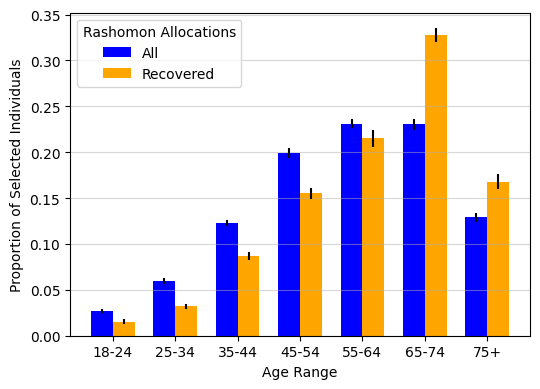

In [90]:
age_labels = ['18-24','25-34', '35-44','45-54', '55-64','65-74', '75+']
x = np.arange(len(age_labels))  # Label locations

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(5.5,4))

# Bar positions and heights
bars1 = ax.bar(x - width/2, ages_baseline.mean(axis=0), width, yerr=1.96*(ages_baseline.std(axis=0)/np.sqrt(len(ages_baseline))), label='All', color='blue')
bars2 = ax.bar(x + width/2, ages_selected.mean(axis=0), width, yerr=1.96*(ages_selected.std(axis=0)/np.sqrt(len(ages_selected))), label='Recovered', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Age Range')
ax.set_ylabel('Proportion of Selected Individuals')
ax.set_xticks(x)
ax.set_xticklabels(age_labels)
ax.legend(title="Rashomon Allocations", loc="upper left")

# Show the plot
plt.grid(True, axis='y', alpha=0.5)
fig.tight_layout()
fig.savefig(output_file, dpi=500)